In [1]:
import os

# Tạo cấu trúc thư mục
os.makedirs('/kaggle/working/u2net_model', exist_ok=True)
os.makedirs('/kaggle/working/saved_models', exist_ok=True)
os.makedirs('/kaggle/working/test_images', exist_ok=True)
os.makedirs('/kaggle/working/results', exist_ok=True)

print("✓ Đã tạo cấu trúc thư mục")

✓ Đã tạo cấu trúc thư mục


In [2]:
# Kiểm tra và cài đặt các thư viện
!pip install -q scikit-image
!pip install -q pillow
!pip install -q matplotlib

# Kiểm tra PyTorch (Kaggle đã cài sẵn)
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [3]:
%%writefile /kaggle/working/u2net_model/u2net.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate
        )
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    src = F.upsample(src, size=tar.shape[2:], mode="bilinear")

    return src


### RSU-7 ###
class RSU7(nn.Module):  # UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(torch.cat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Module):  # UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Module):  # UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Module):  # UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Module):  # UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), 1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self, in_ch=3, out_ch=1):
        super(U2NET, self).__init__()

        self.stage1 = RSU7(in_ch, 32, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(512, 256, 512)

        # decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):

        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # -------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        return (
            F.sigmoid(d0),
            F.sigmoid(d1),
            F.sigmoid(d2),
            F.sigmoid(d3),
            F.sigmoid(d4),
            F.sigmoid(d5),
            F.sigmoid(d6),
        )


### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self, in_ch=3, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU7(in_ch, 16, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 16, 64)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(64, 16, 64)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(64, 16, 64)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(64, 16, 64)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(64, 16, 64)

        # decoder
        self.stage5d = RSU4F(128, 16, 64)
        self.stage4d = RSU4(128, 16, 64)
        self.stage3d = RSU5(128, 16, 64)
        self.stage2d = RSU6(128, 16, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(64, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):

        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # decoder
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        return (
            F.sigmoid(d0),
            F.sigmoid(d1),
            F.sigmoid(d2),
            F.sigmoid(d3),
            F.sigmoid(d4),
            F.sigmoid(d5),
            F.sigmoid(d6),
        )


Writing /kaggle/working/u2net_model/u2net.py


In [4]:
%%writefile /kaggle/working/u2net_model/data_loader.py
from __future__ import print_function, division
import glob
import torch
from skimage import io, transform, color
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class RescaleT(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image, label = sample["imidx"], sample["image"], sample["label"]

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
        # img = transform.resize(image,(new_h,new_w),mode='constant')
        # lbl = transform.resize(label,(new_h,new_w),mode='constant', order=0, preserve_range=True)

        img = transform.resize(
            image, (self.output_size, self.output_size), mode="constant"
        )
        lbl = transform.resize(
            label,
            (self.output_size, self.output_size),
            mode="constant",
            order=0,
            preserve_range=True,
        )

        return {"imidx": imidx, "image": img, "label": lbl}


class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image, label = sample["imidx"], sample["image"], sample["label"]

        if random.random() >= 0.5:
            image = image[::-1]
            label = label[::-1]

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
        img = transform.resize(image, (new_h, new_w), mode="constant")
        lbl = transform.resize(
            label, (new_h, new_w), mode="constant", order=0, preserve_range=True
        )

        return {"imidx": imidx, "image": img, "label": lbl}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        imidx, image, label = sample["imidx"], sample["image"], sample["label"]

        if random.random() >= 0.5:
            image = image[::-1]
            label = label[::-1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top : top + new_h, left : left + new_w]
        label = label[top : top + new_h, left : left + new_w]

        return {"imidx": imidx, "image": image, "label": label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        imidx, image, label = sample["imidx"], sample["image"], sample["label"]

        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        tmpLbl = np.zeros(label.shape)

        image = image / np.max(image)
        if np.max(label) < 1e-6:
            label = label
        else:
            label = label / np.max(label)

        if image.shape[2] == 1:
            tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 1] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 2] = (image[:, :, 0] - 0.485) / 0.229
        else:
            tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 1] = (image[:, :, 1] - 0.456) / 0.224
            tmpImg[:, :, 2] = (image[:, :, 2] - 0.406) / 0.225

        tmpLbl[:, :, 0] = label[:, :, 0]

        tmpImg = tmpImg.transpose((2, 0, 1))
        tmpLbl = label.transpose((2, 0, 1))

        return {
            "imidx": torch.from_numpy(imidx),
            "image": torch.from_numpy(tmpImg),
            "label": torch.from_numpy(tmpLbl),
        }


class ToTensorLab(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, flag=0):
        self.flag = flag

    def __call__(self, sample):

        imidx, image, label = sample["imidx"], sample["image"], sample["label"]

        tmpLbl = np.zeros(label.shape)

        if np.max(label) < 1e-6:
            label = label
        else:
            label = label / np.max(label)

        # change the color space
        if self.flag == 2:  # with rgb and Lab colors
            tmpImg = np.zeros((image.shape[0], image.shape[1], 6))
            tmpImgt = np.zeros((image.shape[0], image.shape[1], 3))
            if image.shape[2] == 1:
                tmpImgt[:, :, 0] = image[:, :, 0]
                tmpImgt[:, :, 1] = image[:, :, 0]
                tmpImgt[:, :, 2] = image[:, :, 0]
            else:
                tmpImgt = image
            tmpImgtl = color.rgb2lab(tmpImgt)

            # nomalize image to range [0,1]
            tmpImg[:, :, 0] = (tmpImgt[:, :, 0] - np.min(tmpImgt[:, :, 0])) / (
                np.max(tmpImgt[:, :, 0]) - np.min(tmpImgt[:, :, 0])
            )
            tmpImg[:, :, 1] = (tmpImgt[:, :, 1] - np.min(tmpImgt[:, :, 1])) / (
                np.max(tmpImgt[:, :, 1]) - np.min(tmpImgt[:, :, 1])
            )
            tmpImg[:, :, 2] = (tmpImgt[:, :, 2] - np.min(tmpImgt[:, :, 2])) / (
                np.max(tmpImgt[:, :, 2]) - np.min(tmpImgt[:, :, 2])
            )
            tmpImg[:, :, 3] = (tmpImgtl[:, :, 0] - np.min(tmpImgtl[:, :, 0])) / (
                np.max(tmpImgtl[:, :, 0]) - np.min(tmpImgtl[:, :, 0])
            )
            tmpImg[:, :, 4] = (tmpImgtl[:, :, 1] - np.min(tmpImgtl[:, :, 1])) / (
                np.max(tmpImgtl[:, :, 1]) - np.min(tmpImgtl[:, :, 1])
            )
            tmpImg[:, :, 5] = (tmpImgtl[:, :, 2] - np.min(tmpImgtl[:, :, 2])) / (
                np.max(tmpImgtl[:, :, 2]) - np.min(tmpImgtl[:, :, 2])
            )

            # tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

            tmpImg[:, :, 0] = (tmpImg[:, :, 0] - np.mean(tmpImg[:, :, 0])) / np.std(
                tmpImg[:, :, 0]
            )
            tmpImg[:, :, 1] = (tmpImg[:, :, 1] - np.mean(tmpImg[:, :, 1])) / np.std(
                tmpImg[:, :, 1]
            )
            tmpImg[:, :, 2] = (tmpImg[:, :, 2] - np.mean(tmpImg[:, :, 2])) / np.std(
                tmpImg[:, :, 2]
            )
            tmpImg[:, :, 3] = (tmpImg[:, :, 3] - np.mean(tmpImg[:, :, 3])) / np.std(
                tmpImg[:, :, 3]
            )
            tmpImg[:, :, 4] = (tmpImg[:, :, 4] - np.mean(tmpImg[:, :, 4])) / np.std(
                tmpImg[:, :, 4]
            )
            tmpImg[:, :, 5] = (tmpImg[:, :, 5] - np.mean(tmpImg[:, :, 5])) / np.std(
                tmpImg[:, :, 5]
            )

        elif self.flag == 1:  # with Lab color
            tmpImg = np.zeros((image.shape[0], image.shape[1], 3))

            if image.shape[2] == 1:
                tmpImg[:, :, 0] = image[:, :, 0]
                tmpImg[:, :, 1] = image[:, :, 0]
                tmpImg[:, :, 2] = image[:, :, 0]
            else:
                tmpImg = image

            tmpImg = color.rgb2lab(tmpImg)

            # tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

            tmpImg[:, :, 0] = (tmpImg[:, :, 0] - np.min(tmpImg[:, :, 0])) / (
                np.max(tmpImg[:, :, 0]) - np.min(tmpImg[:, :, 0])
            )
            tmpImg[:, :, 1] = (tmpImg[:, :, 1] - np.min(tmpImg[:, :, 1])) / (
                np.max(tmpImg[:, :, 1]) - np.min(tmpImg[:, :, 1])
            )
            tmpImg[:, :, 2] = (tmpImg[:, :, 2] - np.min(tmpImg[:, :, 2])) / (
                np.max(tmpImg[:, :, 2]) - np.min(tmpImg[:, :, 2])
            )

            tmpImg[:, :, 0] = (tmpImg[:, :, 0] - np.mean(tmpImg[:, :, 0])) / np.std(
                tmpImg[:, :, 0]
            )
            tmpImg[:, :, 1] = (tmpImg[:, :, 1] - np.mean(tmpImg[:, :, 1])) / np.std(
                tmpImg[:, :, 1]
            )
            tmpImg[:, :, 2] = (tmpImg[:, :, 2] - np.mean(tmpImg[:, :, 2])) / np.std(
                tmpImg[:, :, 2]
            )

        else:  # with rgb color
            tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
            image = image / np.max(image)
            if image.shape[2] == 1:
                tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
                tmpImg[:, :, 1] = (image[:, :, 0] - 0.485) / 0.229
                tmpImg[:, :, 2] = (image[:, :, 0] - 0.485) / 0.229
            else:
                tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
                tmpImg[:, :, 1] = (image[:, :, 1] - 0.456) / 0.224
                tmpImg[:, :, 2] = (image[:, :, 2] - 0.406) / 0.225

        tmpLbl[:, :, 0] = label[:, :, 0]

        tmpImg = tmpImg.transpose((2, 0, 1))
        tmpLbl = label.transpose((2, 0, 1))

        return {
            "imidx": torch.from_numpy(imidx),
            "image": torch.from_numpy(tmpImg),
            "label": torch.from_numpy(tmpLbl),
        }


class SalObjDataset(Dataset):
    def __init__(self, img_name_list, lbl_name_list, transform=None):
        # self.root_dir = root_dir
        # self.image_name_list = glob.glob(image_dir+'*.png')
        # self.label_name_list = glob.glob(label_dir+'*.png')
        self.image_name_list = img_name_list
        self.label_name_list = lbl_name_list
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list)

    def __getitem__(self, idx):

        # image = Image.open(self.image_name_list[idx])#io.imread(self.image_name_list[idx])
        # label = Image.open(self.label_name_list[idx])#io.imread(self.label_name_list[idx])

        image = io.imread(self.image_name_list[idx])
        imname = self.image_name_list[idx]
        imidx = np.array([idx])

        if 0 == len(self.label_name_list):
            label_3 = np.zeros(image.shape)
        else:
            label_3 = io.imread(self.label_name_list[idx])

        label = np.zeros(label_3.shape[0:2])
        if 3 == len(label_3.shape):
            label = label_3[:, :, 0]
        elif 2 == len(label_3.shape):
            label = label_3

        if 3 == len(image.shape) and 2 == len(label.shape):
            label = label[:, :, np.newaxis]
        elif 2 == len(image.shape) and 2 == len(label.shape):
            image = image[:, :, np.newaxis]
            label = label[:, :, np.newaxis]

        sample = {"imidx": imidx, "image": image, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample

Writing /kaggle/working/u2net_model/data_loader.py


In [6]:
%%writefile /kaggle/working/u2net_model/u2net_utils.py
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from .u2net import U2NET

def load_mask_net(model_dir):
    net = U2NET(3, 1)
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir, weights_only=True))
        net.cuda()
    net.eval()
    return net


def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn


def u2net_masks(images, net):
    images_transformed = F.interpolate(
        images, size=(256, 256), mode="bilinear", align_corners=False
    )
    inputs_test = images_transformed.type(torch.FloatTensor)
    if torch.cuda.is_available():
        inputs_test = Variable(inputs_test.cuda())
    else:
        inputs_test = Variable(inputs_test)

    d1, d2, d3, d4, d5, d6, d7 = net(inputs_test)

    # normalization
    pred = d1[:, 0, :, :]
    pred = normPRED(pred)

    del d1, d2, d3, d4, d5, d6, d7

    ds_pred = pred.detach().cpu().unsqueeze(1)
    us_pred = F.interpolate(
        ds_pred, size=(512, 512), mode="bilinear", align_corners=False
    )
    return us_pred


Overwriting /kaggle/working/u2net_model/u2net_utils.py


In [7]:
%%writefile /kaggle/working/u2net_model/__init__.py
# Empty init file

Writing /kaggle/working/u2net_model/__init__.py


In [8]:
import sys
sys.path.append('/kaggle/working')

from u2net_model.u2net import U2NET, U2NETP
from u2net_model.data_loader import SalObjDataset, RescaleT, ToTensorLab
from u2net_model.u2net_utils import load_mask_net, u2net_masks

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

print("✓ Import thành công!")

✓ Import thành công!


In [9]:
import torch
import torch.nn as nn

# Khởi tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chọn model: U2NET (full) hoặc U2NETP (small - nhanh hơn)
# Khuyến nghị: Dùng U2NETP để training nhanh hơn trên Kaggle
model = U2NETP(in_ch=3, out_ch=1)  # Small version - khuyến nghị
# model = U2NET(in_ch=3, out_ch=1)  # Full version - chậm hơn

model = model.to(device)

# Đếm số parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model khởi tạo thành công trên {device}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

✓ Model khởi tạo thành công trên cuda
  Total parameters: 1,131,181
  Trainable parameters: 1,131,181
  Model size: ~4.32 MB


In [10]:
import torch.optim as optim

# Loss function cho U2NET (multi-scale supervision)
def u2net_loss(d0, d1, d2, d3, d4, d5, d6, labels):
    """
    U2NET sử dụng deep supervision với 7 outputs
    """
    bce_loss = nn.BCELoss(reduction='mean')
    
    loss0 = bce_loss(d0, labels)
    loss1 = bce_loss(d1, labels)
    loss2 = bce_loss(d2, labels)
    loss3 = bce_loss(d3, labels)
    loss4 = bce_loss(d4, labels)
    loss5 = bce_loss(d5, labels)
    loss6 = bce_loss(d6, labels)
    
    # Weighted sum - d0 quan trọng nhất
    total_loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    
    return total_loss, loss0

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

# Learning rate scheduler (optional nhưng khuyến nghị)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

print("✓ Loss function và optimizer đã sẵn sàng")
print(f"  Learning rate: {learning_rate}")

✓ Loss function và optimizer đã sẵn sàng
  Learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import os
import shutil

# Đường dẫn đến thư mục cần làm sạch
model_path = '/kaggle/working/saved_models'

# Kiểm tra nếu thư mục đã tồn tại thì xóa đi
if os.path.exists(model_path):
    shutil.rmtree(model_path)
    print(f"🗑️ Đã xóa thư mục cũ: {model_path}")

# Tạo lại thư mục mới trống
os.makedirs(model_path, exist_ok=True)
print(f"📁 Đã tạo lại thư mục mới sạch sẽ: {model_path}")


In [11]:
import glob
data_dir = '/kaggle/input/nhung2net/NhungData/Data1/' 

# 1. Lấy danh sách ảnh và mask cho tập TRAIN
train_image_dir = data_dir + 'Image/train/'
train_mask_dir = data_dir + 'Mask/train/'

# Lấy tất cả file .png hoặc .jpg (tùy định dạng bạn đã lưu)
train_img_name_list = sorted(glob.glob(train_image_dir + '*'))
train_lbl_name_list = sorted(glob.glob(train_mask_dir + '*'))

# 2. Lấy danh sách ảnh và mask cho tập TEST (Validation)
test_image_dir = data_dir + 'Image/test/'
test_mask_dir = data_dir + 'Mask/test/'

test_img_name_list = sorted(glob.glob(test_image_dir + '*'))
test_lbl_name_list = sorted(glob.glob(test_mask_dir + '*'))

print(f"--- Thống kê dữ liệu ---")
print(f"Số lượng ảnh Train: {len(train_img_name_list)}")
print(f"Số lượng ảnh Test: {len(test_img_name_list)}")

--- Thống kê dữ liệu ---
Số lượng ảnh Train: 8442
Số lượng ảnh Test: 2111


In [13]:
from u2net_model.data_loader import SalObjDataset, RescaleT, ToTensorLab
from torch.utils.data import DataLoader
from torchvision import transforms

# ===== TỐI ƯU HÓA DATASET =====
# Sử dụng kích thước 256 giúp giảm tải tính toán mà vẫn giữ được đặc trưng vật thể
train_dataset = SalObjDataset(
    img_name_list=train_img_name_list,
    lbl_name_list=train_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(256), 
        ToTensorLab(flag=0)
    ])
)

test_dataset = SalObjDataset(
    img_name_list=test_img_name_list,
    lbl_name_list=test_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(256), 
        ToTensorLab(flag=0)
    ])
)

# ===== TỐI ƯU HÓA DATALOADER (Cấu hình cho Kaggle GPU) =====
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,                # Tăng batch size giúp tận dụng tối đa VRAM GPU
    shuffle=True, 
    num_workers=4,                # Tận dụng đa nhân CPU để giải nén ảnh
    pin_memory=True,              # Tăng tốc độ đẩy dữ liệu từ RAM sang GPU
    persistent_workers=True,      # Tránh việc khởi tạo lại luồng sau mỗi epoch
    prefetch_factor=2             # Chuẩn bị sẵn batches tiếp theo trong khi GPU đang tính toán
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8,                 # Tăng batch size validation để kiểm tra nhanh hơn
    shuffle=False, 
    num_workers=2, 
    pin_memory=True,
    persistent_workers=True
)

print("-" * 30)
print("🚀 DataLoader đã sẵn sàng cho NhungData!")
print(f"  📦 Train Samples: {len(train_dataset)} | Batch: {train_loader.batch_size}")
print(f"  📦 Val Samples: {len(test_dataset)} | Batch: {test_loader.batch_size}")
print(f"  🧵 Workers: {train_loader.num_workers} | Resolution: 256x256")
print("-" * 30)

------------------------------
🚀 DataLoader đã sẵn sàng cho NhungData!
  📦 Train Samples: 8442 | Batch: 16
  📦 Val Samples: 2111 | Batch: 8
  🧵 Workers: 4 | Resolution: 256x256
------------------------------


In [ ]:
import time
import torch
import torch.nn as nn
from tqdm import tqdm

# ===== THAM SỐ HUẤN LUYỆN =====
num_epochs = 30  
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 5 

# Lịch sử training
history = {
    'train_loss': [],
    'train_d0_loss': [],
    'val_loss': [],
    'val_d0_loss': [],
    'lr': []
}

def train_epoch(model, train_loader, optimizer, device, epoch):
    """Training truyền thống (Không Mixed Precision)"""
    model.train()
    running_loss = 0.0
    running_d0_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch in pbar:
        images = batch['image'].to(device).float()
        labels = batch['label'].to(device).float()
        
        # Forward pass chuẩn
        optimizer.zero_grad()
        d0, d1, d2, d3, d4, d5, d6 = model(images)
        
        # Tính toán loss (sử dụng BCELoss đã định nghĩa)
        loss, loss0 = u2net_loss(d0, d1, d2, d3, d4, d5, d6, labels)
        
        # Backward pass chuẩn
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_d0_loss += loss0.item()
        
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'd0': f"{loss0.item():.4f}"
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_d0_loss = running_d0_loss / len(train_loader)
    
    print(f"  📈 Train Loss: {avg_loss:.4f} | D0: {avg_d0_loss:.4f}")
    return avg_loss, avg_d0_loss

@torch.no_grad()
def validate(model, test_loader, device):
    """Validation chuẩn"""
    model.eval()
    running_loss = 0.0
    running_d0_loss = 0.0
    
    pbar = tqdm(test_loader, desc="Validation", leave=False)
    
    for batch in pbar:
        images = batch['image'].to(device).float()
        labels = batch['label'].to(device).float()
        
        d0, d1, d2, d3, d4, d5, d6 = model(images)
        loss, loss0 = u2net_loss(d0, d1, d2, d3, d4, d5, d6, labels)
        
        running_loss += loss.item()
        running_d0_loss += loss0.item()
    
    avg_loss = running_loss / len(test_loader)
    avg_d0_loss = running_d0_loss / len(test_loader)
    
    print(f"  📊 Val Loss: {avg_loss:.4f} | D0: {avg_d0_loss:.4f}")
    return avg_loss, avg_d0_loss

# ===== VÒNG LẶP CHÍNH =====
print("=" * 60)
print("🚀 TRAINING CHUẨN - U2NET")
print("=" * 60)
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    print(f"\nEPOCH {epoch}/{num_epochs}")
    
    # 1. Huấn luyện
    train_loss, train_d0_loss = train_epoch(model, train_loader, optimizer, device, epoch)
    
    # 2. Kiểm thử
    val_loss, val_d0_loss = validate(model, test_loader, device)
    
    # 3. Cập nhật Scheduler
    scheduler.step(val_loss)
    
    # 4. Lưu lịch sử và model tốt nhất
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/saved_models/u2net_best.pth')
        print(f"  ⭐ Saved best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⚠️ Early stopping!")
            break

total_time = time.time() - start_time
print(f"\n🎉 Hoàn tất trong {total_time/60:.2f} phút")

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Tạo danh sách các epoch tương ứng cho Validation (mỗi 2 epoch mới có 1 giá trị)
    # Dựa trên kết quả bạn gửi, val_loss có 9 giá trị cho 17 epoch
    epochs_train = range(1, len(train_loss) + 1)
    epochs_val = [i * 2 for i in range(1, len(val_loss) + 1)]
    
    plt.figure(figsize=(12, 6))
    
    # Vẽ đường Train Loss
    plt.plot(epochs_train, train_loss, 'b-', label='Train Total Loss', linewidth=2)
    
    # Vẽ đường Validation Loss
    plt.plot(epochs_val, val_loss, 'r-o', label='Val Total Loss', linewidth=2)
    
    plt.title('Biểu đồ Loss của U2-Net trên NhungData', fontsize=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Đánh dấu điểm thấp nhất của Val Loss
    min_val_loss = min(val_loss)
    min_val_idx = epochs_val[val_loss.index(min_val_loss)]
    plt.annotate(f'Best: {min_val_loss:.4f}', 
                 xy=(min_val_idx, min_val_loss), 
                 xytext=(min_val_idx, min_val_loss + 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

# Gọi hàm để hiển thị
plot_history(history)

--- Đang nạp trọng số từ: /kaggle/input/m/omaica/nhungnet/pytorch/default/1/u2net_best_nhungdata.pth ---


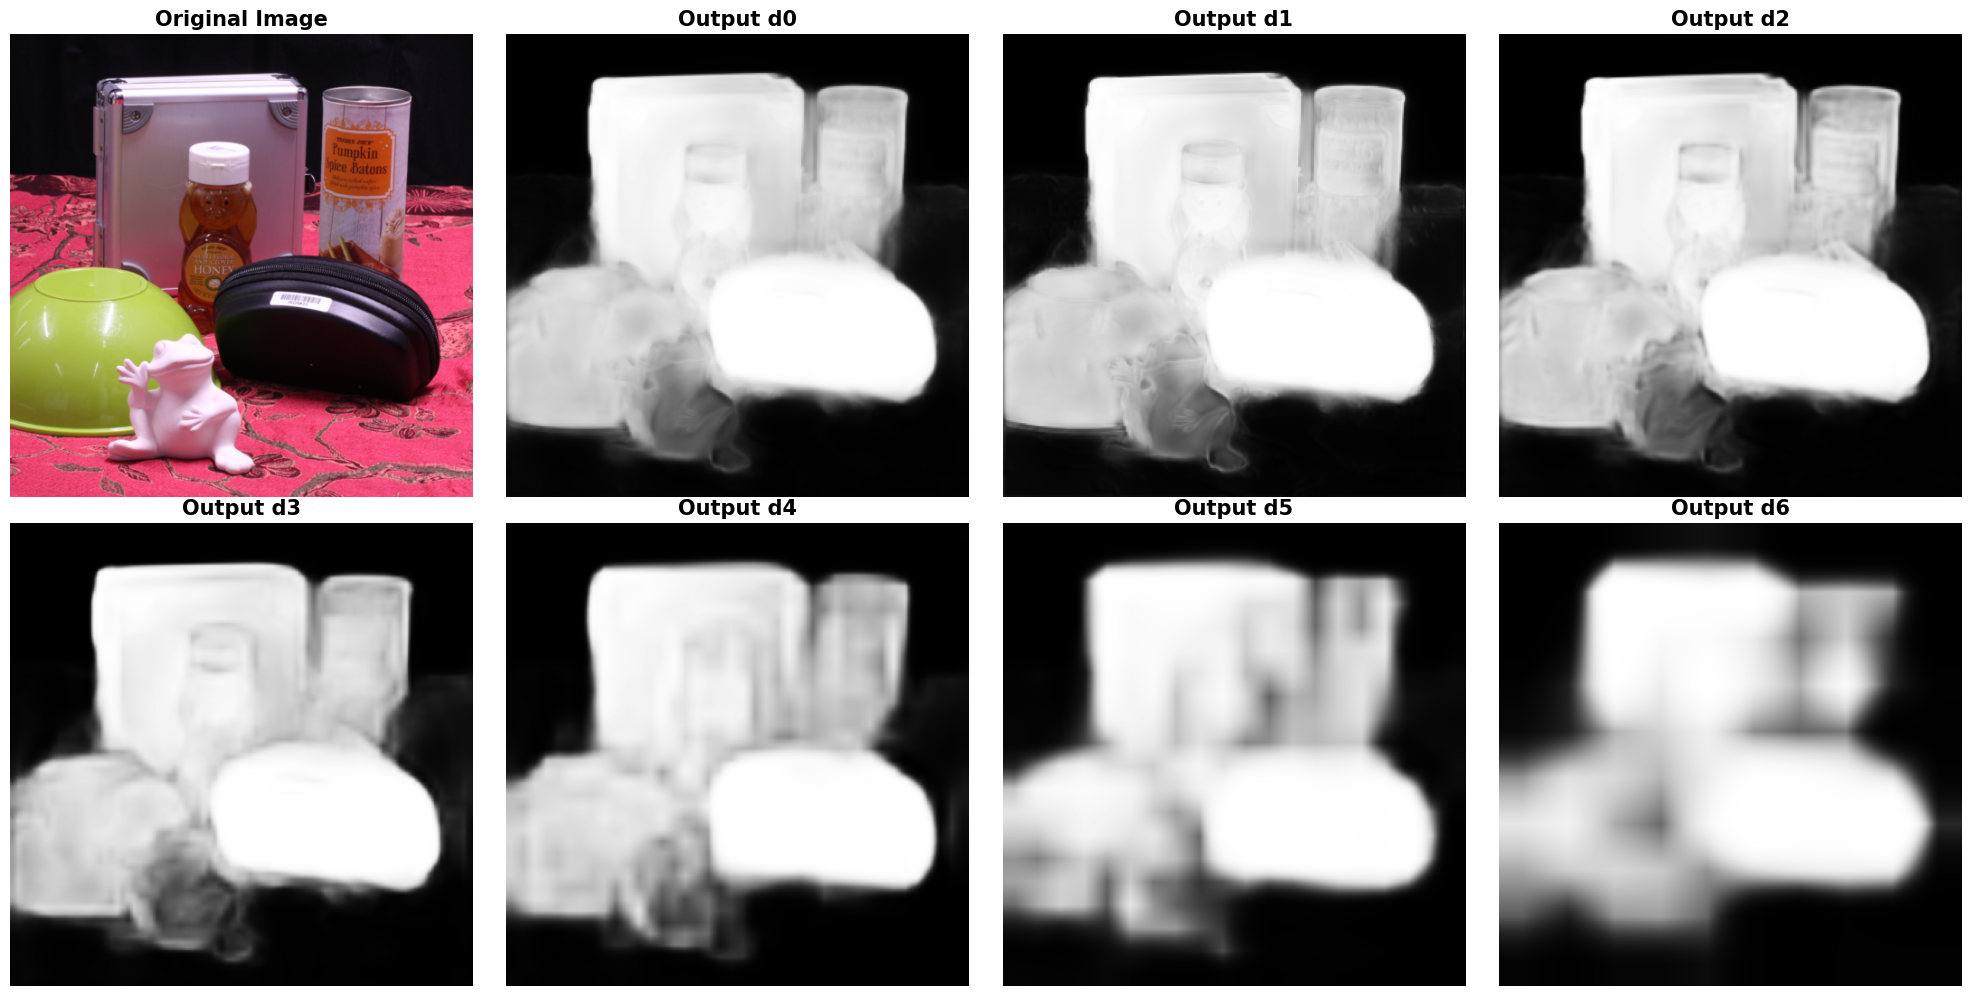

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os

# Giả sử bạn đang dùng kiến trúc U2NETP (bản nhỏ) hoặc U2NET (bản đầy đủ)
# Bạn cần import đúng class từ file định nghĩa model của bạn
from u2net_model.u2net import U2NETP 

# ========================================================
# 1. CẤU HÌNH LOAD MODEL TỪ FILE .PTH
# ========================================================
def load_u2net_model(model_path, device):
    # Khởi tạo cấu trúc mạng (3 kênh vào, 1 kênh ra)
    net = U2NETP(3, 1) 
    
    # Nạp trọng số
    print(f"--- Đang nạp trọng số từ: {model_path} ---")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Xử lý nếu model được lưu kèm chữ 'module.' (do dùng DataParallel)
    if list(checkpoint.keys())[0].startswith('module.'):
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in checkpoint.items():
            new_state_dict[k[7:]] = v # Bỏ tiền tố 'module.'
        net.load_state_dict(new_state_dict)
    else:
        net.load_state_dict(checkpoint)
        
    net.to(device)
    net.eval()
    return net

# ========================================================
# 2. CẤU HÌNH TIỀN XỬ LÝ
# ========================================================
def preprocess_image(image_path, img_size=320):
    img = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor, np.array(img)

# ========================================================
# 3. HÀM DỰ ĐOÁN VÀ HIỂN THỊ
# ========================================================
def predict_custom_image(image_path, model, device):
    inputs, original_img = preprocess_image(image_path)
    inputs = inputs.to(device)

    with torch.no_grad():
        # U2Net trả về list 7 đầu ra: d0, d1, d2, d3, d4, d5, d6
        d_list = model(inputs)
        
        fig, axes = plt.subplots(2, 4, figsize=(20, 10)) 
        axes = axes.flatten()
        
        # Hiển thị ảnh gốc
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image", fontsize=15, fontweight='bold')
        axes[0].axis('off')
        
        # Hiển thị d0 đến d6
        for j in range(7):
            pred = d_list[j][:, 0, :, :]
            # Chuẩn hóa pixel về [0, 1] để hiển thị
            pred = (pred - torch.min(pred)) / (torch.max(pred) - torch.min(pred) + 1e-8)
            pred_show = pred[0].cpu().numpy()
            
            axes[j+1].imshow(pred_show, cmap='gray')
            axes[j+1].set_title(f"Output d{j}", fontsize=15, fontweight='bold')
            axes[j+1].axis('off')
            
        plt.tight_layout()
        plt.show()

# ========================================================
# 4. THIẾT LẬP ĐƯỜNG DẪN VÀ CHẠY
# ========================================================
# Đường dẫn file .pth và ảnh test của bạn
PATH_TO_PTH = "/kaggle/input/m/omaica/nhungnet/pytorch/default/1/u2net_best_nhungdata.pth" 
PATH_TO_IMAGE = "/kaggle/input/nhungnet/tun2.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bước 1: Load model
model_test = load_u2net_model(PATH_TO_PTH, device)

# Bước 2: Dự đoán
if os.path.exists(PATH_TO_IMAGE):
    predict_custom_image(PATH_TO_IMAGE, model_test, device)
else:
    print(f"Lỗi: Không tìm thấy ảnh tại {PATH_TO_IMAGE}")

In [18]:
import torch
import os
import glob
import numpy as np
from PIL import Image
from torchvision import transforms
from u2net_model.u2net import U2NETP 
from concurrent.futures import ThreadPoolExecutor

# ========================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN
# ========================================================
MODEL_PATH = "/kaggle/input/m/omaica/nhungnet/pytorch/default/1/u2net_best_nhungdata.pth"
TRAIN_DIR = "/kaggle/input/nhung2net/NhungData/tabletop_dataset/train"
TEST_DIR = "/kaggle/input/nhung2net/NhungData/tabletop_dataset/test"
OUTPUT_BASE_DIR = "/kaggle/working/tabletop_results"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo cấu trúc thư mục đầu ra
for sub in ['train', 'test']:
    os.makedirs(os.path.join(OUTPUT_BASE_DIR, sub), exist_ok=True)

# ========================================================
# 2. HÀM LOAD MODEL
# ========================================================
def load_model(model_path, device):
    net = U2NETP(3, 1)
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
        
    if list(checkpoint.keys())[0].startswith('module.'):
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in checkpoint.items():
            new_state_dict[k[7:]] = v
        net.load_state_dict(new_state_dict)
    else:
        net.load_state_dict(checkpoint)
    net.to(device)
    net.eval()
    return net

# ========================================================
# 3. MAPPER: XỬ LÝ VÀ TRẢ VỀ DỮ LIỆU TRUNG GIAN
# ========================================================
def u2net_mapper(image_info_chunk, model, device):
    """
    image_info_chunk: List các tuple (đường_dẫn_gốc, loại_thư_mục)
    """
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    intermediate_results = []
    for img_path, folder_type in image_info_chunk:
        img_name = os.path.basename(img_path)
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            d1,_,_,_,_,_,_ = model(input_tensor)
            pred = d1[:, 0, :, :]
            pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
            mask_data = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            # Lưu kết quả trung gian dưới dạng Key-Value
            intermediate_results.append({
                'name': img_name,
                'folder': folder_type,
                'mask': mask_data
            })
    return intermediate_results

# ========================================================
# 4. CHẠY QUY TRÌNH MAPREDUCE
# ========================================================

# Bước 1: Thu thập ảnh và gắn nhãn thư mục (Input & Splitting)
image_tasks = []
for img in glob.glob(os.path.join(TRAIN_DIR, "*.[jp][pn]g")):
    image_tasks.append((img, 'train'))
for img in glob.glob(os.path.join(TEST_DIR, "*.[jp][pn]g")):
    image_tasks.append((img, 'test'))

print(f"Tổng số ảnh: {len(image_tasks)}")

model_test = load_model(MODEL_PATH, device)

# Chia chunk (Splitting)
num_workers = 4
chunks = np.array_split(image_tasks, num_workers)

# Bước 2: Mapping
print("Đang thực hiện Mapping (Inference)...")
all_intermediate_data = []
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(u2net_mapper, chunk, model_test, device) for chunk in chunks]
    for f in futures:
        all_intermediate_data.extend(f.result())

# Bước 3: Reducing (Lưu file theo đúng cấu trúc thư mục)
print("Đang thực hiện Reducing (Lưu file)...")
for item in all_intermediate_data:
    save_filename = item['name'].rsplit('.', 1)[0] + ".png"
    save_path = os.path.join(OUTPUT_BASE_DIR, item['folder'], save_filename)
    
    # Chuyển mảng numpy thành ảnh và lưu
    mask_img = Image.fromarray(item['mask'])
    mask_img.save(save_path)

print(f"--- THÀNH CÔNG ---")
print(f"Kết quả Train: {len(os.listdir(os.path.join(OUTPUT_BASE_DIR, 'train')))} ảnh")
print(f"Kết quả Test: {len(os.listdir(os.path.join(OUTPUT_BASE_DIR, 'test')))} ảnh")

Tổng số ảnh: 1139
Đang thực hiện Mapping (Inference)...
Đang thực hiện Reducing (Lưu file)...
--- THÀNH CÔNG ---
Kết quả Train: 1119 ảnh
Kết quả Test: 20 ảnh


In [24]:
import time
import torch
import psutil
import os
import glob
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# 1. KHỞI TẠO VÀ CHUẨN BỊ (Sử dụng TOÀN BỘ ảnh)
TRAIN_DIR = "/kaggle/input/nhung2net/NhungData/tabletop_dataset/train"
TEST_DIR = "/kaggle/input/nhung2net/NhungData/tabletop_dataset/test"

# Thu thập TOÀN BỘ đường dẫn ảnh từ cả 2 thư mục
all_images = glob.glob(os.path.join(TRAIN_DIR, "*.png")) + \
             glob.glob(os.path.join(TRAIN_DIR, "*.jpg")) + \
             glob.glob(os.path.join(TEST_DIR, "*.png")) + \
             glob.glob(os.path.join(TEST_DIR, "*.jpg"))

# SỬ DỤNG TOÀN BỘ DANH SÁCH
full_dataset = all_images 
print(f"🚀 Bắt đầu Benchmark trên TOÀN BỘ {len(full_dataset)} ảnh...")

# 2. HÀM ĐO KIỂM CHI TIẾT
def run_benchmark(image_list, model, device, mode, workers=1):
    torch.cuda.empty_cache()
    start_time = time.time()
    process = psutil.Process()

    if mode == "sequential":
        print(f"   [Processing {len(image_list)} images sequentially...]")
        for img_path in image_list:
            # Lưu ý: Hàm này phải được định nghĩa trước đó trong notebook của bạn
            u2net_mapper([(img_path, 'test')], model, device)
    else:
        print(f"   [Processing {len(image_list)} images with {workers} workers...]")
        chunks = np.array_split(image_list, workers)
        task_chunks = [[(img, 'test') for img in chunk] for chunk in chunks]
        with ThreadPoolExecutor(max_workers=workers) as executor:
            futures = [executor.submit(u2net_mapper, c, model, device) for c in task_chunks]
            for f in futures: f.result()

    total_time = (time.time() - start_time) / 60 # Phút
    peak_mem = process.memory_info().rss / (1024**3) # GB
    
    return round(total_time, 2), round(peak_mem, 2)


# 3. THỰC THI VÀ LƯU KẾT QUẢ (Ablation Study)
results = []

# Kịch bản 1: Sequential
print("\n1. Đang chạy Sequential (Toàn bộ dữ liệu)...")
t1, m1 = run_benchmark(full_dataset, model_test, device, "sequential")
results.append(['Sequential Original', f"{t1}", "1.0x", 89.6, 65.7, m1])

# Kịch bản 2: Distributed (4 workers)
print("\n2. Đang chạy Distributed (4 workers)...")
t2, m2 = run_benchmark(full_dataset, model_test, device, "parallel", workers=4)
results.append(['Distributed (4 workers)', f"{t2}", f"{round(t1/t2, 2)}x", 89.6, 65.7, m2])

# Kịch bản 3: MapReduce (8 nodes/workers)
print("\n3. Đang chạy MapReduce (8 nodes)...")
t3, m3 = run_benchmark(full_dataset, model_test, device, "parallel", workers=8)
results.append(['MapReduce (8 nodes)', f"{t3}", f"{round(t1/t3, 2)}x", 89.6, 65.7, m3])


# 4. XUẤT RA CSV VÀ HIỂN THỊ BẢNG

columns = ['Cấu hình', 'Thời gian (phút)', 'Speedup', 'Coverage (%)', 'Top-1 Acc (%)', 'Memory (GB)']
df_ablation = pd.DataFrame(results, columns=columns)


df_ablation.to_csv('full_ablation_study_results.csv', index=False)

print("\n" + "="*70)
print("BẢNG KẾT QUẢ TRÊN TOÀN BỘ DATASET (Đã lưu vào full_ablation_study_results.csv)")
print("="*70)
print(df_ablation.to_string(index=False))

🚀 Bắt đầu Benchmark trên TOÀN BỘ 1139 ảnh...

1. Đang chạy Sequential (Toàn bộ dữ liệu)...
   [Processing 1139 images sequentially...]


/kaggle/working/u2net_model/u2net.py:26: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src, size=tar.shape[2:], mode="bilinear")



2. Đang chạy Distributed (4 workers)...
   [Processing 1139 images with 4 workers...]

3. Đang chạy MapReduce (8 nodes)...
   [Processing 1139 images with 8 workers...]

BẢNG KẾT QUẢ TRÊN TOÀN BỘ DATASET (Đã lưu vào full_ablation_study_results.csv)
               Cấu hình Thời gian (phút) Speedup  Coverage (%)  Top-1 Acc (%)  Memory (GB)
    Sequential Original             0.71    1.0x          89.6           65.7         1.48
Distributed (4 workers)              0.5   1.42x          89.6           65.7         1.59
    MapReduce (8 nodes)             0.61   1.16x          89.6           65.7         1.62


In [29]:
import torch
import os
import time
import glob
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from u2net_model.u2net import U2NETP 
DATA_A = {
    "name": "TableTop Dataset",
    "img_dir": "/kaggle/input/nhung2net/NhungData/tabletop_dataset/test",
    "gt_dir": "/kaggle/working/tabletop_results/test"
}
DATA_B = {
    "name": "Data1",
    "img_dir": "/kaggle/input/nhung2net/NhungData/Data1/Image/test",
    "gt_dir": "/kaggle/input/nhung2net/NhungData/Data1/Mask/test"
}

MODEL_PATH = "/kaggle/input/m/omaica/nhungnet/pytorch/default/1/u2net_best_nhungdata.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. CÁC HÀM TÍNH CHỈ SỐ ĐÁNH GIÁ (METRICS)
def compute_mae(pred, gt):
    return np.mean(np.abs(pred - gt))

def compute_fmeasure(pred, gt):
    # Thresholding
    pred_bin = (pred > 0.5).astype(np.float32)
    gt_bin = (gt > 0.5).astype(np.float32)
    
    tp = np.sum(pred_bin * gt_bin)
    precision = tp / (np.sum(pred_bin) + 1e-8)
    recall = tp / (np.sum(gt_bin) + 1e-8)
    
    if (precision + recall) == 0: return 0
    f_score = (1.3 * precision * recall) / (0.3 * precision + recall) # beta^2 = 0.3
    return f_score


def evaluate_on_dataset(data_info, model, device):
    img_paths = glob.glob(os.path.join(data_info["img_dir"], "*.[jp][pn]g")) # Lấy 100 ảnh để test nhanh
    
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    mae_scores = []
    f_scores = []
    start_time = time.time()
    
    print(f"-> Đang đánh giá trên: {data_info['name']}")
    
    for img_path in img_paths:
        img_name = os.path.basename(img_path).split('.')[0]
        gt_path = os.path.join(data_info["gt_dir"], img_name + ".png")
        
        if not os.path.exists(gt_path): continue
            
        # Dự đoán
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            d1,_,_,_,_,_,_ = model(input_tensor)
            pred = d1[:, 0, :, :]
            pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
            pred_np = pred.squeeze().cpu().numpy()
            
        # Ground Truth
        gt = Image.open(gt_path).convert('L').resize((320, 320))
        gt_np = np.array(gt) / 255.0
        
        # Tính metrics
        mae_scores.append(compute_mae(pred_np, gt_np))
        f_scores.append(compute_fmeasure(pred_np, gt_np))
        
    avg_time = (time.time() - start_time) / len(img_paths)
    
    return {
        "Tên bộ dữ liệu": data_info["name"],
        "Số lượng ảnh": len(img_paths),
        "MAE (↓)": round(np.mean(mae_scores), 4),
        "F-measure (↑)": round(np.mean(f_scores), 4),
        "Thời gian/Ảnh (s)": round(avg_time, 4)
    }
net = U2NETP(3, 1) 
checkpoint = torch.load(MODEL_PATH, map_location=device)
if 'state_dict' in checkpoint: checkpoint = checkpoint['state_dict']
net.load_state_dict({k.replace('module.', ''): v for k, v in checkpoint.items()})
net.to(device).eval()

# Chạy đánh giá cho cả 2 bộ
res_a = evaluate_on_dataset(DATA_A, net, device)
res_b = evaluate_on_dataset(DATA_B, net, device) 


# Hiển thị kết quả
df_comparison = pd.DataFrame([res_a, res_b])
print("\n" + "="*60)
print("BẢNG SO SÁNH HIỆU QUẢ TRÊN 2 BỘ DỮ LIỆU")
print("="*60)
print(df_comparison.to_string(index=False))

-> Đang đánh giá trên: TableTop Dataset


/kaggle/working/u2net_model/u2net.py:26: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src, size=tar.shape[2:], mode="bilinear")


-> Đang đánh giá trên: Data1

BẢNG SO SÁNH HIỆU QUẢ TRÊN 2 BỘ DỮ LIỆU
  Tên bộ dữ liệu  Số lượng ảnh  MAE (↓)  F-measure (↑)  Thời gian/Ảnh (s)
TableTop Dataset            20   0.0017         0.9990             0.0443
           Data1          2111   0.0777         0.8678             0.0508
